# Predição de alunos que fizeram Enem 2016 apenas como teste - Semana 9
### Treineiro ou não Treineiro, eis a questão ...

![image](https://user-images.githubusercontent.com/32513366/89333007-baf95000-d66a-11ea-88ae-55cf23b1e01c.png)


**Por**: Kaike Wesley Reis

## Módulos

In [205]:
# Misc
import warnings
from time import sleep

# Manipulação de Dados
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Análise de dados
import missingno as msno

# Seleção de features
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score, accuracy_score

# Modelagem
from sklearn.tree import DecisionTreeClassifier

# Comandos do notebook
warnings.filterwarnings('ignore')
%matplotlib inline

# Pré-processamento

## Importação dos dados

In [63]:
# Importação
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv')

## Avaliar quais colunas existem no conjunto de treino e teste

In [64]:
print('No conjunto de treino existem',len(train.columns),'e no conjunto de teste existem',len(test.columns),'colunas.')

No conjunto de treino existem 166 e no conjunto de teste existem 43 colunas.


## Emparelhamento das colunas dos datasets (treino e teste)
Não vale a pena usar colunas que **não existem** no conjunto de teste para treinar o modelo, pois não teremos como prever o resultado final com elas.

In [65]:
train = train[['IN_TREINEIRO'] + list(test.columns)]

## Criar coluna para predição no conjunto de teste

In [66]:
test['IN_TREINEIRO']= np.nan

## Análise de valores faltantes

### A) Fazer um overview da quantidade de valores faltantes para ambos os conjuntos

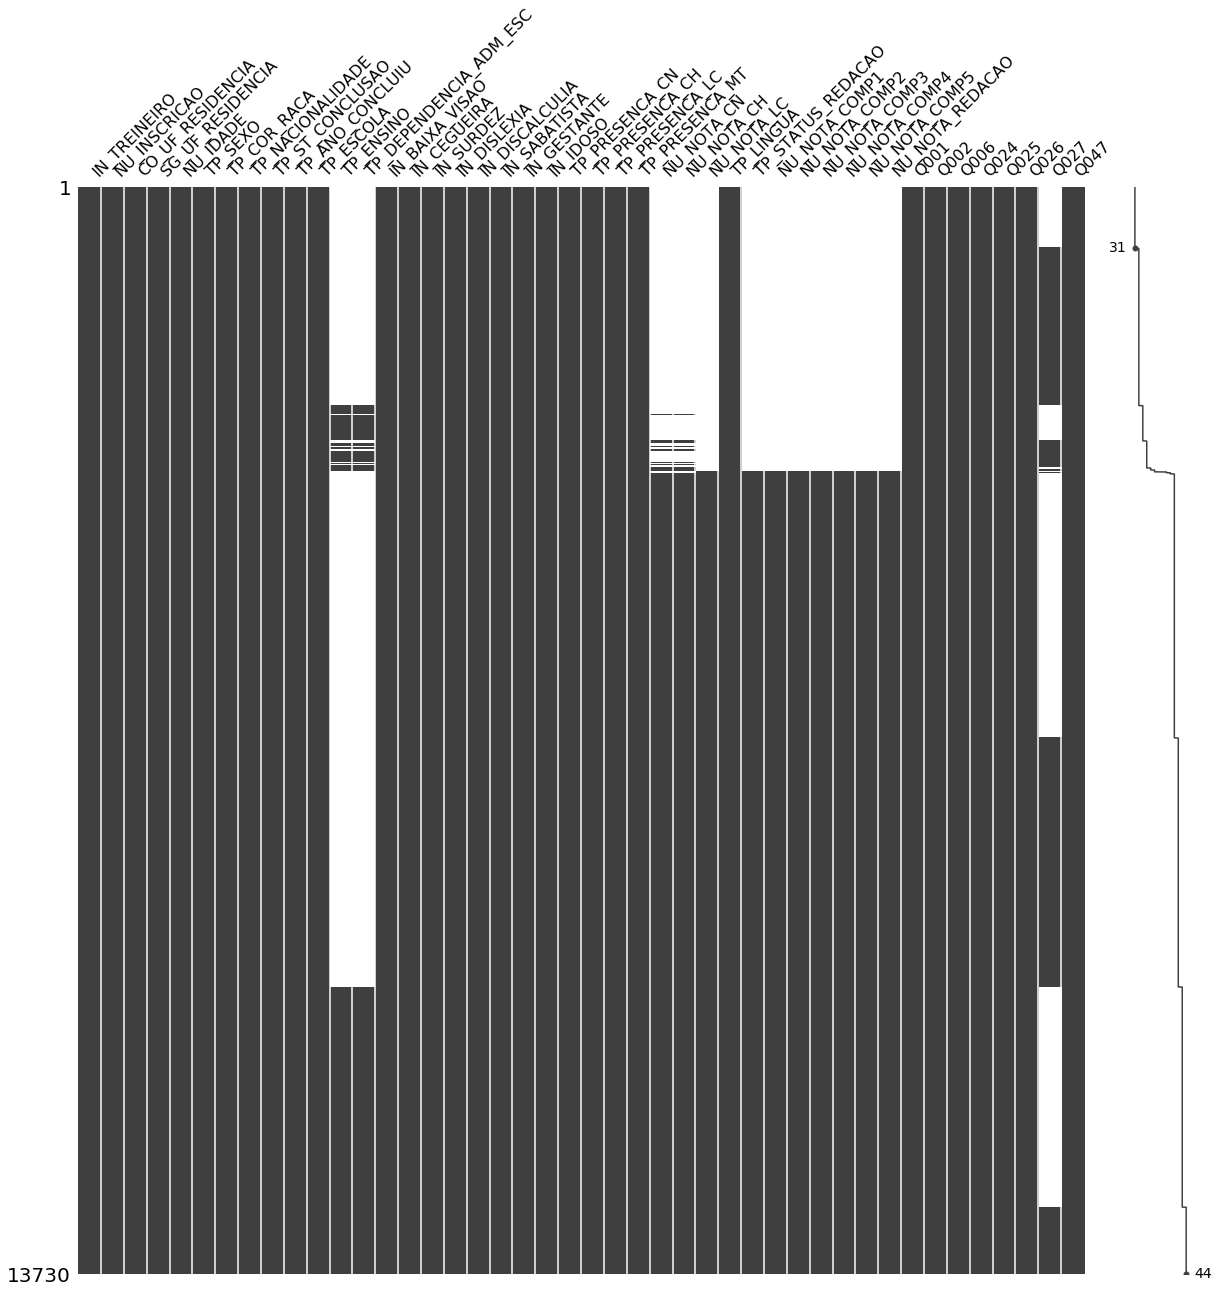

In [67]:
# Nullity Matrix para conjunto de treinamento
msno.matrix(train, sort='ascending', figsize=(20, 20));

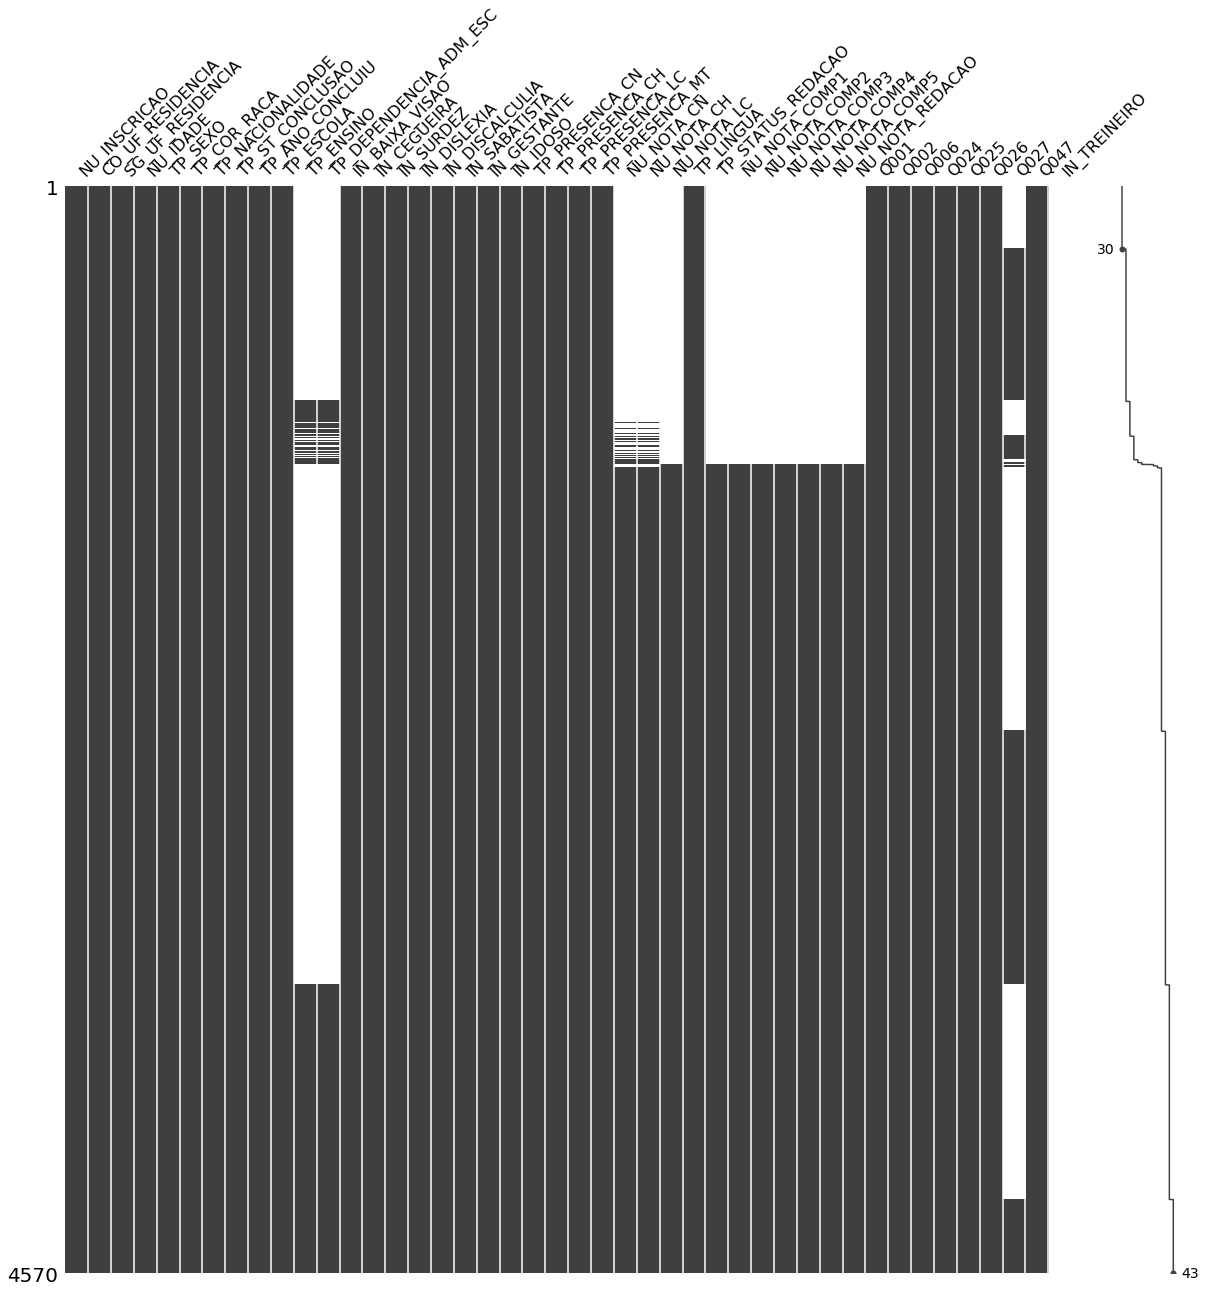

In [68]:
# Nullity Matrix para conjunto de teste
msno.matrix(test, sort='ascending', figsize=(20, 20));

Colocando esses gráficos em % podemos entender melhor a quantidade real de valores faltantes por coluna.

### B) Plot de valores faltantes por features em ambos os datasets

In [69]:
def plot_nan_porcentagem_por_coluna(df):
    # Cria dataset auxiliar
    nan_per_column = pd.DataFrame(df.isna().sum(),columns=['nanValues']).reset_index()
    # Calcular % de NaN  para cada feature
    for i in range(0,len(nan_per_column)):
        nan_per_column.loc[i, 'nanValuesPct'] = 100*round(nan_per_column.loc[i, 'nanValues']/len(df),3)
    # Manter apenas no dataset auxiliar as variaveis que apresentem NaN % acima de um valor
    nan_per_column = nan_per_column[nan_per_column['nanValuesPct'] > 0]
    
    # Plot
    plt.figure(figsize=(30,15))
    sns.barplot(y="index", x="nanValuesPct", data=nan_per_column)
    plt.ylabel('Variáveis', fontsize=20)
    plt.xlabel('% Faltante', fontsize=20)
    plt.title('Gráfico em % de valores faltantes', fontsize=30)
    plt.yticks(fontsize=15)
    plt.xticks([0,10,20,30,40,50,60,70,80,90,100], fontsize=15)

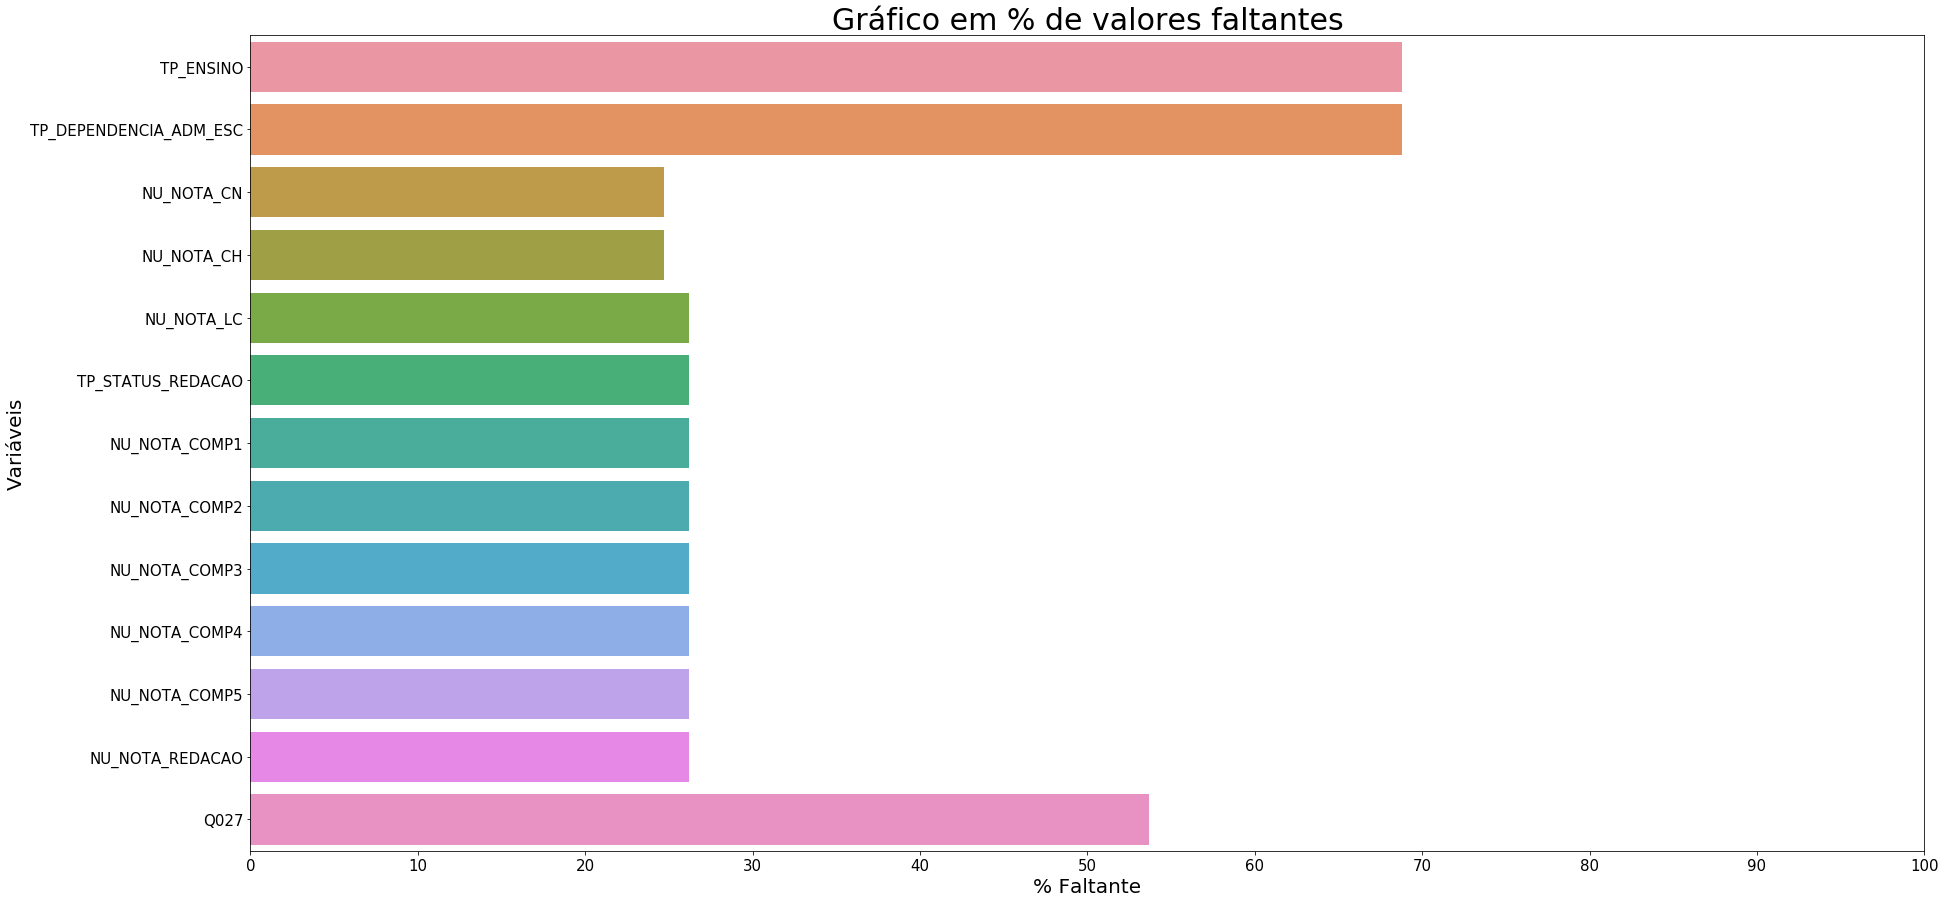

In [70]:
# Gráfico de NaN para treino
plot_nan_porcentagem_por_coluna(train)

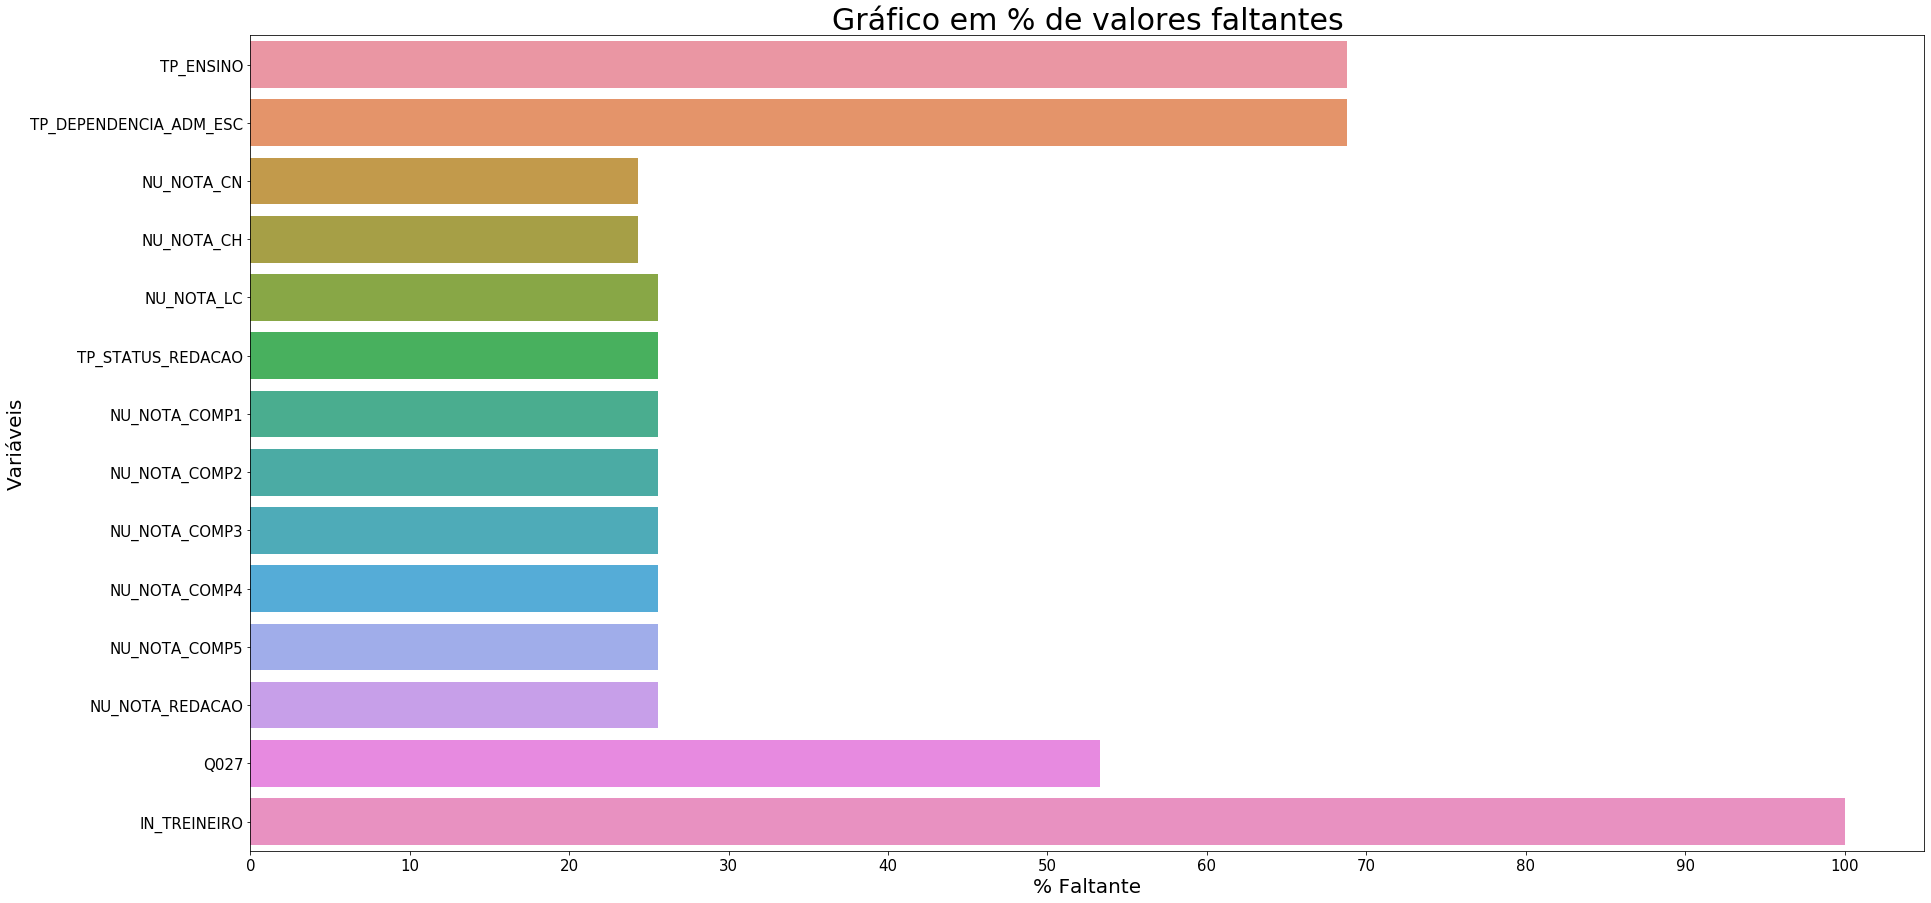

In [71]:
# Gráfico de NaN para teste
plot_nan_porcentagem_por_coluna(test)

### Comentário
Vemos que `Q027`, `TP_ENSINO` e `TP_DEPENDENCIA_ADM_ESC` apresentam mais de 50% de valores faltantes em ambos os datasets. Diferente do desafio anterior, por se tratar de variáveis de cunho mais pessoal vamos analisar se existe alguma relação entre os valores faltantes dessas variáveis e nossa variável objetivo `IN_TREINEIRO`.

## Análise gráfica: Valores faltantes

### A) Definir funções para auxiliar

In [72]:
def pegar_colunas_com_missing(dataset):
    # Adquirir quantidade de valores faltantes por coluna
    valores_nan_qtd = train.isna().sum() > 0
    # Retornar as colunas que apresentam pelo menos um valor faltante
    return valores_nan_qtd[valores_nan_qtd == True].index.values     

In [73]:
def criar_colunas_para_missing_info(dataset):
    colunas_nan = pegar_colunas_com_missing(dataset)
    for col in colunas_nan:
        dataset['nan_'+col] = np.where(pd.isna(dataset[col]), 1, 0)

### B) Gerar colunas referente aos missings

In [74]:
# Criar as colunas
criar_colunas_para_missing_info(train)

In [75]:
# Selecionar apenas essas colunas + target
nan_cols = [x for x in train.columns if x.split('_')[0] == 'nan']

### C) Plot de barras

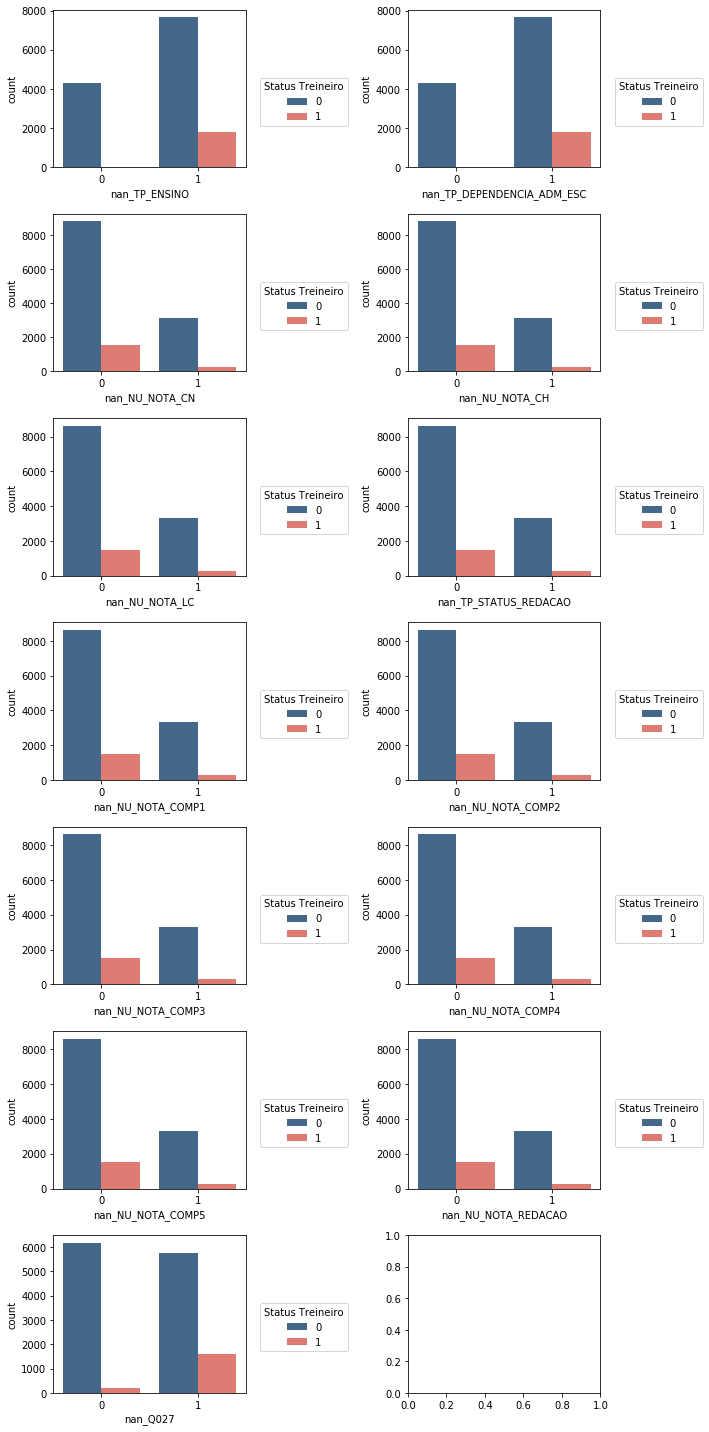

In [76]:
# Plot
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10,20))

r = 0      # Index da linha
c = 0      # Index da coluna

# Loop nas features para plot
for f in nan_cols:
    # Plot de barras
    sns.countplot(x=f, hue='IN_TREINEIRO', data=train, palette={0:'#386796',1:'#F06C61'}, ax=axes[r][c])
    # Configurações do plot
    axes[r][c].legend(title='Status Treineiro', loc='right center',bbox_to_anchor=(1.05, 0.6))
    
    # Controle do index
    c += 1
    if c > 1:
        c = 0
        r += 1
# Configurações do plot x2
plt.tight_layout()

#### Comentários:
Através da análise gráfica `nan_TP_ENSINO` e `nan_TP_DEPENDENCIA_ADM_ESC` se destacam por mostrar que nessa base de dados de treino, todos os participantes que foram pro ENEM 2016 como Treineiros não colocaram informações nessas categoriais. Além dessas duas colunas, `nan_Q027` mostra um compartamento similar.

Outro ponto muito interessante é que as variáveis referente a notas e status da redação mostram um padrão semelhante, visualmente falando, o que pode indicar que esses valores faltantes ocorreram para os mesmos estudantes.

#### Analisando mais de perto essas colunas faltantes para notas ...

In [77]:
sum(train['nan_NU_NOTA_COMP1'] == train['nan_NU_NOTA_COMP2'])/len(train)

1.0

In [78]:
sum(train['nan_NU_NOTA_COMP1'] == train['nan_NU_NOTA_COMP3'])/len(train)

1.0

In [79]:
sum(train['nan_NU_NOTA_COMP1'] == train['nan_NU_NOTA_COMP4'])/len(train)

1.0

In [80]:
sum(train['nan_NU_NOTA_COMP1'] == train['nan_NU_NOTA_COMP5'])/len(train)

1.0

In [81]:
sum(train['nan_NU_NOTA_COMP1'] == train['nan_TP_STATUS_REDACAO'])/len(train)

1.0

In [82]:
sum(train['nan_NU_NOTA_COMP1'] == train['nan_NU_NOTA_REDACAO'])/len(train)

1.0

In [83]:
sum(train['nan_NU_NOTA_COMP1'] == train['nan_NU_NOTA_CN'])/len(train)

0.9796067006554989

In [84]:
sum(train['nan_NU_NOTA_COMP1'] == train['nan_Q027'])/len(train)

0.38266569555717406

**Aparentemente as colunas de `nan` referente as redações são equivalentes, porém se diferem das colunas de nota e Q027.**

In [85]:
sum(train['nan_NU_NOTA_CN'] == train['nan_NU_NOTA_CH'])/len(train)

1.0

In [86]:
sum(train['nan_NU_NOTA_CN'] == train['nan_NU_NOTA_LC'])/len(train)

0.9796067006554989

In [87]:
sum(train['nan_NU_NOTA_CN'] == train['nan_Q027'])/len(train)

0.38761835396941

In [88]:
sum(train['nan_NU_NOTA_LC'] == train['nan_Q027'])/len(train)

0.38266569555717406

#### Resultado
Resumindo, as colunas do tipo `nan` são ...
- Equivalentes no que se referem ao tema de redação e, portanto, redundantes.
- As colunas  de notas podem ser resumidas aos dias de avaliação, onde `CN` e `CH` foram idênticas (ocorrem no mesmo dia), porém `CN` e `LC` (ocorrem em dias diferentes).
- `nan_Q027` é única 

Portanto, irei reduzir essa alta redundância e alterar os nomes das colunas `nan_TP_STATUS_REDACAO`, `nan_NU_NOTA_CN` e `nan_NU_NOTA_LC` para `NF_nan_REDACAO`, `NF_nan_NOTAS_DIA_1` e `NF_nan_NOTAS_DIA_2` respectivamente onde `NF` implica Nova Feature:

In [89]:
# Remover colunas
train.drop(axis=1,inplace=True,columns=['nan_NU_NOTA_COMP1','nan_NU_NOTA_COMP2','nan_NU_NOTA_COMP3','nan_NU_NOTA_COMP4',
                                        'nan_NU_NOTA_COMP5','nan_NU_NOTA_REDACAO','nan_NU_NOTA_CH'])

In [90]:
# Alterar nome das colunas
train.rename(columns={'nan_TP_STATUS_REDACAO': 'NF_nan_REDACAO', 'nan_NU_NOTA_CN': 'NF_nan_NOTAS_DIA_1',
                      'nan_NU_NOTA_LC': 'NF_nan_NOTAS_DIA_2'}, inplace=True)

O mesmo será feito para as features `['nan_TP_ENSINO','nan_TP_DEPENDENCIA_ADM_ESC','nan_Q027']` que receberam NF na frente:

In [91]:
# Alterar nome das colunas
train.rename(columns={'nan_TP_ENSINO': 'NF_nan_TP_ENSINO', 'nan_TP_DEPENDENCIA_ADM_ESC': 'NF_nan_TP_DEPENDENCIA_ADM_ESC',
                      'nan_Q027': 'NF_nan_Q027'}, inplace=True)

## Definir os tipos de variáveis
Tipos:
- Categóricas
- Numéricas
- Faltantes

E será definido o label também.

In [92]:
# Numericas
vars_numericas = [x for x in train.columns if x.split('_')[0] == 'NU']
# Remover Inscricao
vars_numericas = vars_numericas[1:]

In [93]:
# Categoricas
vars_categoricas = [x for x in train.columns if x.split('_')[0] not in ['NU','NF','nan']]
# Remover variável target IN_TREINEIRO
vars_categoricas = vars_categoricas[1:]

In [94]:
# Faltantes
vars_faltantes = ['NF_nan_TP_ENSINO','NF_nan_TP_DEPENDENCIA_ADM_ESC','NF_nan_NOTAS_DIA_1','NF_nan_NOTAS_DIA_2',
                  'NF_nan_REDACAO', 'NF_nan_Q027']

In [95]:
# Variavel target - Label
label = 'IN_TREINEIRO'

## Análise gráfica: Variáveis numéricas
Exploração visual das variáveis com teor numérico.

In [96]:
# Visualizar as variáveis numéricas
vars_numericas

['NU_IDADE',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO']

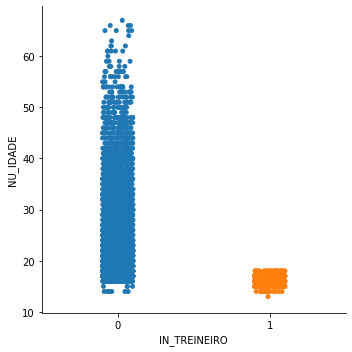

In [97]:
# Variável numérica mais divisória
sns.catplot(x=label, y=vars_numericas[0], data=train);

### Comentário
A variável `NU_IDADE` foi a feature numérica que mais mostrou um bom poder de divisão em comparação as outras features numéricas, através da visualização gráfica. Esse mesmo gráfico foi realizado para as outras variáveis, porém não apresentavam o mesmo poder claro de divisão como idade e portanto não estão neste notebook.

Através desse gráfico é possível notar uma clara distinção: os estudantes treineiros são sempre novos. Isso reflete muito a realidade, onde os estudantes do ensino médio fazem o ENEM antes do 3º ano para treinar suas habilidades. Créditos ao [trabalho de Clarisse](https://github.com/ClarisseAlvarenga/codenation_aceleradev_ds/blob/master/Desafio_Codenation_Semana_09.ipynb) que conseguiu identificar essa relação.

## Análise gráfica: Variáveis categóricas

Exploração visual das variáveis com teor categórico.

In [98]:
# Visualizar as variáveis categóricas
vars_categoricas

['CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'TP_PRESENCA_MT',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047']

### Hipótese I - Os estudantes treineiros tendem a faltar mais!

Para avaliar essa hipótese, vamos verificar as variáveis `TP_PRESENCA`:

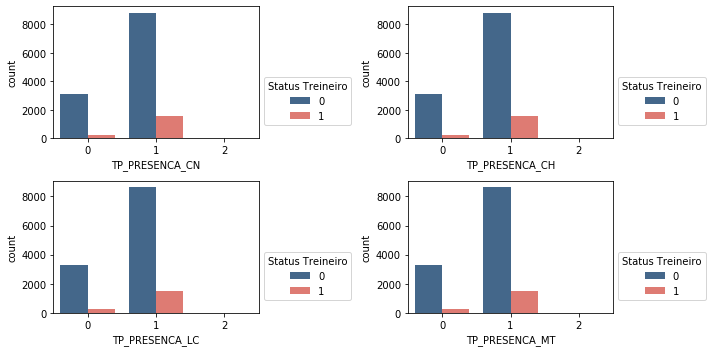

In [99]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

r = 0      # Index da linha
c = 0      # Index da coluna

# Loop nas features para plot
for f in ['TP_PRESENCA_CN','TP_PRESENCA_CH','TP_PRESENCA_LC','TP_PRESENCA_MT']:
    # Plot de barras
    sns.countplot(x=f, hue='IN_TREINEIRO', data=train, palette={0:'#386796',1:'#F06C61'}, ax=axes[r][c])
    # Configurações do plot
    axes[r][c].legend(title='Status Treineiro', loc='right center',bbox_to_anchor=(1, 0.5))
    # Controle do index
    c += 1
    if c > 1:
        c = 0
        r += 1
# Configurações do plot x2
plt.tight_layout()

#### Resultado
Por uma análise gráfica, o que ocorre é exatamente o contrário: treineiros tendem no geral estar presentes. Além disso, de forma geral as features aparentam resultados semelhantes (mesmo tamanho de barras). 

Como o ENEM funciona em dois dias de prova, o aluno que faltar determinado tema, por exemplo LC, faltará outro tema que ocorrerá no mesmo dia, neste caso MT. O mesmo é válido para eliminação.

### Hipótese II - Variáveis do tipo `TP_PRESENCA` podem ser resumidas para um conjunto menor de acordo aos dias de provas

In [100]:
# Verificar para o dia 1
sum(train['TP_PRESENCA_CN'] == train['TP_PRESENCA_CH'])/len(train)

1.0

In [101]:
# Verificar para o dia 2
sum(train['TP_PRESENCA_LC'] == train['TP_PRESENCA_MT'])/len(train)

1.0

In [102]:
# Verificar hipótese extra - TP_PRESENCA pode ser resumida para uma só variável
sum(train['TP_PRESENCA_LC'] == train['TP_PRESENCA_CH'])/len(train)

0.9792425345957757

#### Comentário
Através de uma comparação elemento a elemento para as variáveis de presença de acordo ao dia, podemos verificar que de fato quem falta uma determinada matéria para um dia, falta todas as outras daquele dia. Porém essa generalização para por ai: se uma pessoa faltou um dos dias não significa que ela faltará o outro como foi visto na hipótese extra.

Dado esse resultado, será mantido uma coluna de presença para cada dia: `TP_PRESENCA_LC` para 2º Dia e `TP_PRESENCA_CN` para 1º Dia:

In [103]:
# Remover dos datasets
train.drop(axis=1,inplace=True,columns=['TP_PRESENCA_MT','TP_PRESENCA_CH'])

Além disso, podemos fazer um comparativo com as features criadas para os valores `nan` de acordo ao dia:

In [104]:
train[['NF_nan_NOTAS_DIA_2','TP_PRESENCA_LC','NF_nan_NOTAS_DIA_1','TP_PRESENCA_CN']].head(5)

,NF_nan_NOTAS_DIA_2,TP_PRESENCA_LC,NF_nan_NOTAS_DIA_1,TP_PRESENCA_CN
1,0,1,0,1
2,0,1,0,1
3,1,0,1,0
4,1,0,1,0
5,1,0,1,0


In [105]:
# Criar uma copia do dataset para auxiliar nessa comparação
aux = train[['NF_nan_NOTAS_DIA_2','TP_PRESENCA_LC','NF_nan_NOTAS_DIA_1','TP_PRESENCA_CN']].copy()
# Aplicar uma mascara e inverter 0 e 1 nas colunas de presença
aux[['TP_PRESENCA_LC','TP_PRESENCA_CN']] = aux[['TP_PRESENCA_LC','TP_PRESENCA_CN']].replace({0:1,1:0})

In [106]:
# Realizar a comparação
len(aux) - sum(aux['NF_nan_NOTAS_DIA_2'] == aux['TP_PRESENCA_LC'])

5

In [107]:
# Realizar a comparação
len(aux) - sum(aux['NF_nan_NOTAS_DIA_1'] == aux['TP_PRESENCA_CN'])

9

In [108]:
# Avaliar as amostras distintas
aux[aux['NF_nan_NOTAS_DIA_2'] != aux['TP_PRESENCA_LC']][['NF_nan_NOTAS_DIA_2','TP_PRESENCA_LC']]

,NF_nan_NOTAS_DIA_2,TP_PRESENCA_LC
546,1,2
1305,1,2
2080,1,2
2744,1,2
3114,1,2


In [109]:
# Avaliar as amostras distintas
aux[aux['NF_nan_NOTAS_DIA_1'] != aux['TP_PRESENCA_CN']][['NF_nan_NOTAS_DIA_1','TP_PRESENCA_CN']]

,NF_nan_NOTAS_DIA_1,TP_PRESENCA_CN
430,1,2
915,1,2
1281,1,2
1776,1,2
548,1,2
1677,1,2
2550,1,2
3080,1,2
3332,1,2


As colunas são equivalentes. O valor `2` apenas indica pessoas que foram eliminadas (o que convenhamos não difere tanto para o algoritmo essa informação). Portanto, as features `TP_PRESENCA` serão eliminadas do dataset:

In [110]:
# Eliminar dataset auxiliar da analise
del aux

In [111]:
# Remover dos datasets
train.drop(axis=1,inplace=True,columns=['TP_PRESENCA_CN','TP_PRESENCA_LC'])

Assim as features `NF_nan_NOTAS_DIA_1` e `NF_nan_NOTAS_DIA_2` podem ser compreendidas como alunos que tiveram notas veridicas naquele dia.

In [112]:
# Alterar lista de variáveis categoricas
vars_categoricas = [x for x in vars_categoricas if x not in ['TP_PRESENCA_MT','TP_PRESENCA_CH','TP_PRESENCA_CN',
                                                             'TP_PRESENCA_LC']]

In [113]:
vars_categoricas

['CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047']

#### Resultado
Essa análise conseguiu reduzir a dimensionalidade dos dados (menos features para trabalhar). Essa mesma idéia poderá ser levantada para as features faltantes também futuramente.

### Hipótese III - Existe algum padrão entre o fato de um estudante ser treineiro com as variáveis `TP`?

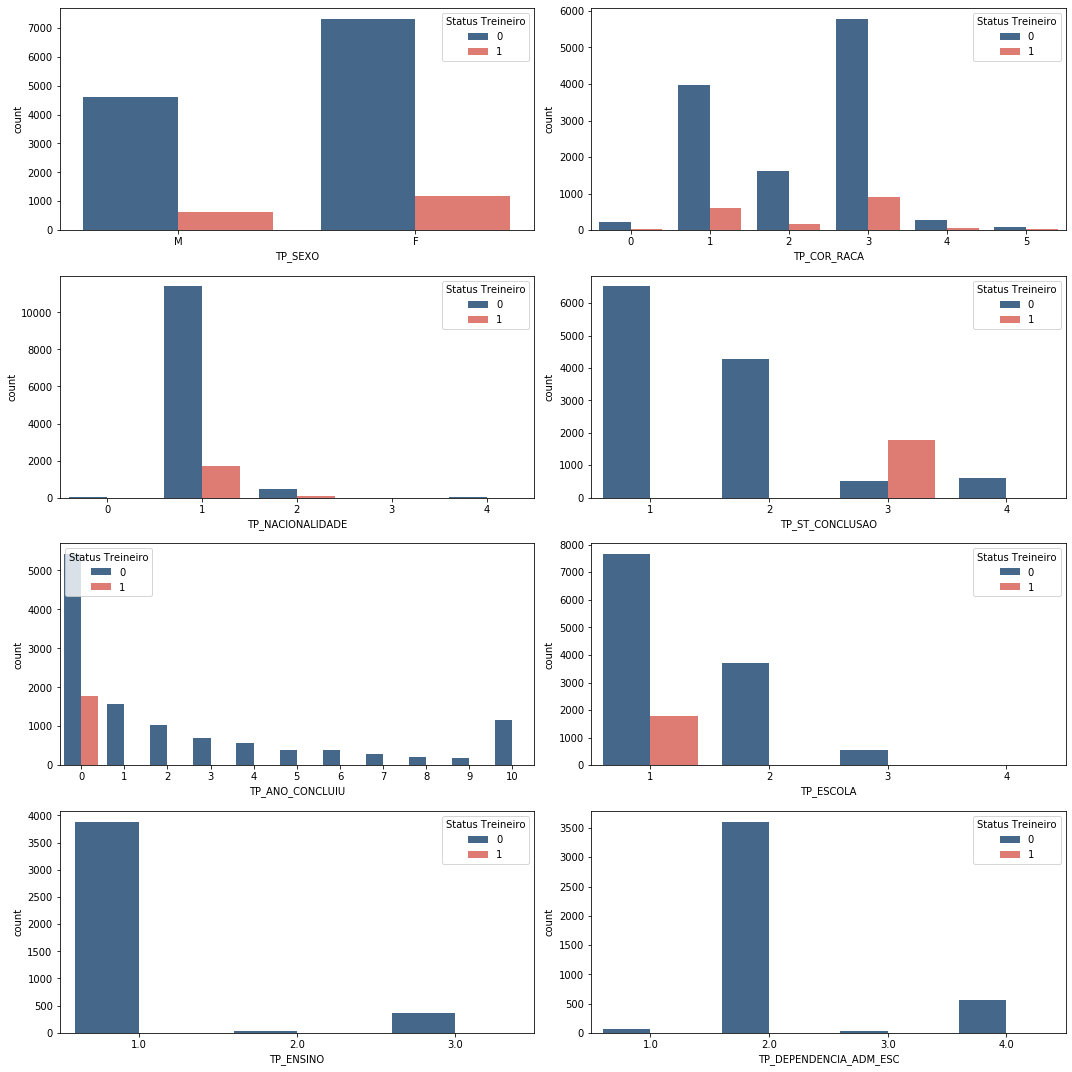

In [114]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

r = 0      # Index da linha
c = 0      # Index da coluna

# Loop nas features para plot
for f in ['TP_SEXO','TP_COR_RACA','TP_NACIONALIDADE','TP_ST_CONCLUSAO','TP_ANO_CONCLUIU',
          'TP_ESCOLA','TP_ENSINO','TP_DEPENDENCIA_ADM_ESC']:
    # Plot de barras
    sns.countplot(x=f, hue='IN_TREINEIRO', data=train, palette={0:'#386796',1:'#F06C61'}, ax=axes[r][c])
    # Configurações do plot
    axes[r][c].legend(title='Status Treineiro', loc='right upper')
    
    # Controle do index
    c += 1
    if c > 1:
        c = 0
        r += 1

# Configurações do plot x2
plt.tight_layout()

#### Resultado
Diversas informações podem ser tiradas desse gráfico:
- 1) `TP_ENSINO` e `TP_DEPENDENCIA_ADM_ESC` não apresentam contagem para estudantes que foram treineiros. Isso fica mais evidente quando olhamos os resultados dos gráficos de mesmo tipo referente aos valores faltantes dessas variáveis: `nan_TP_ENSINO` e `nan_TP_DEPENDENCIA_ADM_ESC` apresentam que todos os treineiros não colocaram responderam essa variável.
- 2) As variáveis `TP_ANO_CONCLUIU`, `TP_ESCOLA` e `TP_ST_CONCLUSAO` mostram que estudantes treineiros responderam a mesma resposta sendo elas 0, 1 e 3 respectivamente. Vamos analisar mais a fundo essas variáveis futuramente.
- 3) `TP_NACIONALIDADE` mostrou que todos os dos treineiros são brasileiros ou naturalizados. Considerando que estamos no brasil isso é bem óbvio, porém caso o estudante seja de fora isso pode ser um ótimo preditor para dizer o oposto: ele não é treineiro.
- 4) As demais variáveis não mostraram um padrão claro ou relevante. Além disso, `TP_SEXO` e `TP_COR_RACA` pode trazer um enviesamento desnecessário ao modelo, por exemplo assumir que uma pessoa parda tem mais chances de ser treineiro (nesse caso em específico pode não ser tão impactante, porém para outros tipos de modelo isso pode ser bastante péssimo).

A partir desses resultados irei:

**Analisar as classes dominantes dos treineiros para as variáveis:** `TP_ANO_CONCLUIU`, `TP_ESCOLA` e `TP_ST_CONCLUSAO`

Primeiro vamos as definições:
- `TP_ANO_CONCLUIU` Ano de Conclusão do Ensino Médio. A categoria dominante `0` indica que o ano de conclusão não foi informado. Essa informação é fortalecida com o gráfico referente as idades, onde todos os treineiros possuem uma idade relativamente baixa.
- `TP_ESCOLA` Tipo de escola do Ensino Médio. A categoria dominante `1` indica que o estudante não informou. Isso pode mostrar um padrão de que os estudantes tendem a responder menos os questionários no geral. Isso será verificado com mais detalhe nas análises futuras.
- `TP_ST_CONCLUSAO` Situação de conclusão do Ensino Médio. A categoria dominante `3` indica os estudantes que estão cursando e irão concluir o Ensino Médio após 2016. Essa informação é bem equivalente ao `TP_ANO_CONCLUIU`.

Com essas informações em mãos, irei aplicar uma redução de complexidade, gerando colunas binárias para essas colunas (`NF` representa New Feature):

In [115]:
# TP_ST_CONCLUSAO :: (1) caso não tenha concluido e (0) para outras variáveis
train['NF_NAO_CONCLUIU_EM'] = np.where(train['TP_ST_CONCLUSAO'] == 3, 1, 0)

In [116]:
# TP_ESCOLA :: (1) para estudantes que não informaram o tipo de escola e (0) para outras categorias
train['NF_ESCOLA_NAO_INFORMADO'] = np.where(train['TP_ESCOLA'] == 1, 1, 0)

In [117]:
# TP_ANO_CONCLUIU :: (1) para estudantes que não informaram e (0) para outras categorias
train['NF_ANO_CONCLUSAO_NAO_INFORMADO'] = np.where(train['TP_ANO_CONCLUIU'] == 0, 1, 0)

**Remover as variáveis enviesadas** `TP_SEXO` **e** `TP_COR_RACA`

In [118]:
# Remover dos datasets
train.drop(axis=1,inplace=True,columns=['TP_SEXO','TP_COR_RACA'])

In [119]:
# Remover as variáveis da lista de categoricas
vars_categoricas = [x for x in vars_categoricas if x not in ['TP_SEXO','TP_COR_RACA']]

**Criar feature referente ao estudante ser brasileiro/naturalizado a partir da variável** `TP_NACIONALIDADE`, **onde** `1` **são os estudantes brasileiros/naturalizados e** `0` **são as demais categorias**

In [120]:
train['NF_EH_BR'] = np.where((train['TP_NACIONALIDADE'] == 1)&(train['TP_NACIONALIDADE'] == 2), 1, 0)

**Eliminar as features** `TP_ENSINO` **e** `TP_DEPENDENCIA_ADM_ESC` **do dataset e trabalhar apenas com as colunas** `nan_` **referentes a elas dado a invariância presente nas mesmas.**

In [121]:
# Remover dos datasets
train.drop(axis=1,inplace=True,columns=['TP_ENSINO','TP_DEPENDENCIA_ADM_ESC'])

In [122]:
# Remover as variáveis da lista de categoricas
vars_categoricas = [x for x in vars_categoricas if x not in ['TP_ENSINO','TP_DEPENDENCIA_ADM_ESC']]

### Hipótese IV - Existe algum padrão entre o fato de um estudante ser treineiro com as variáveis `IN`?

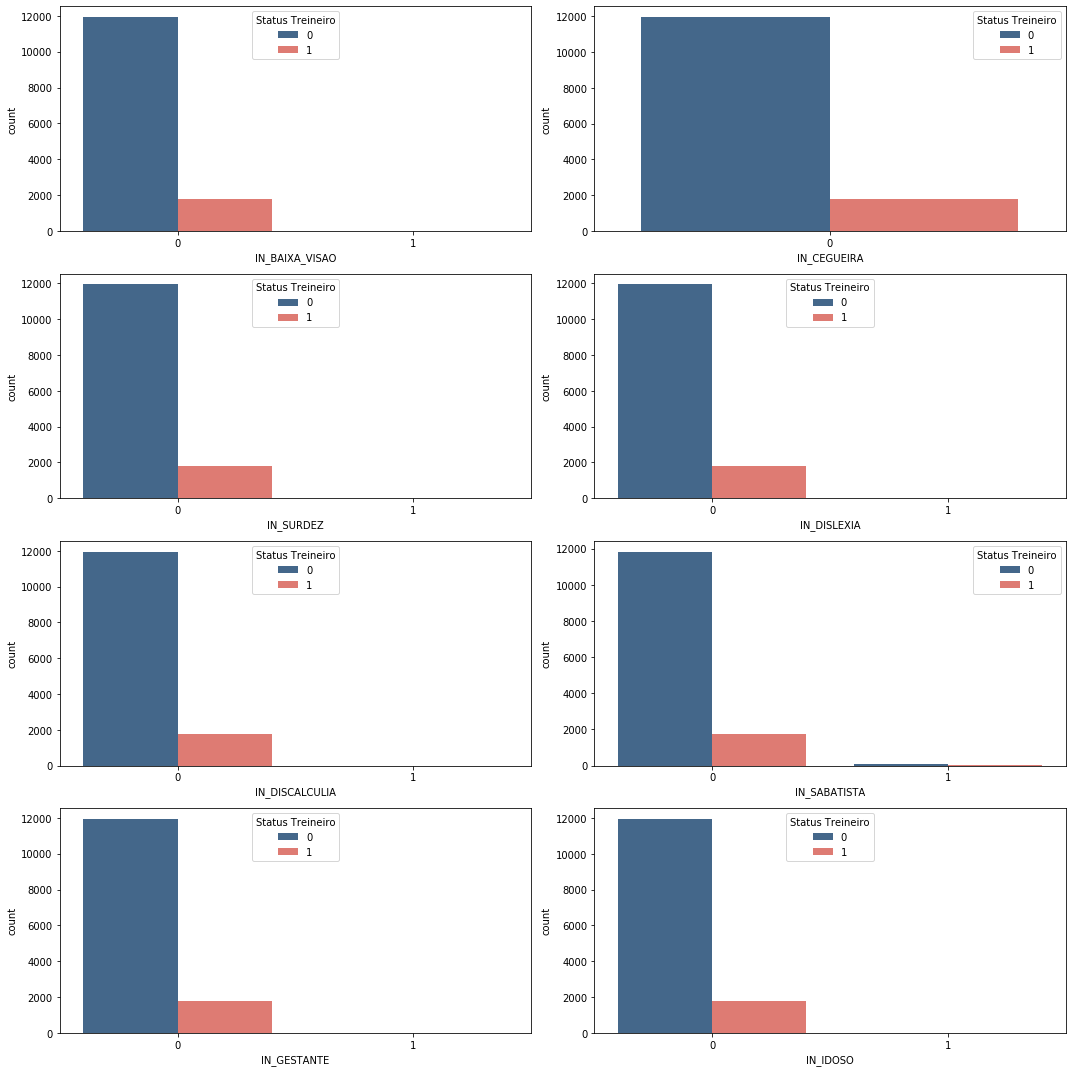

In [123]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

r = 0      # Index da linha
c = 0      # Index da coluna

# Loop nas features para plot
for f in ['IN_BAIXA_VISAO','IN_CEGUEIRA','IN_SURDEZ','IN_DISLEXIA','IN_DISCALCULIA','IN_SABATISTA','IN_GESTANTE','IN_IDOSO']:
    # Plot de barras
    sns.countplot(x=f, hue='IN_TREINEIRO', data=train, palette={0:'#386796',1:'#F06C61'}, ax=axes[r][c])
    # Configurações do plot
    axes[r][c].legend(title='Status Treineiro', loc='right upper')
    
    # Controle do index
    c += 1
    if c > 1:
        c = 0
        r += 1

# Configurações do plot x2
plt.tight_layout()

#### Resultado
No geral, não existe nenhuma distinção clara entre ser treineiro e as colunas `IN`. Inclusive o resultado da coluna `IN_IDOSO` é bem explicado pelo resultado pela feature `NU_IDADE` onde todos os treineiros de fato eram pessoas mais jovens. 

Para análises futuras irei desconsiderar essas variáveis. Caso o modelo elaborado aqui não apresente bons resultados, essas variáveis serão reavalidas.

In [124]:
train.drop(axis=1, inplace=True, columns=['IN_BAIXA_VISAO','IN_CEGUEIRA','IN_SURDEZ','IN_DISLEXIA',
                                          'IN_DISCALCULIA','IN_SABATISTA','IN_GESTANTE','IN_IDOSO'])

### Hipótese Extra - Existe alguma relação entre o estado e o participante ser treineiro?

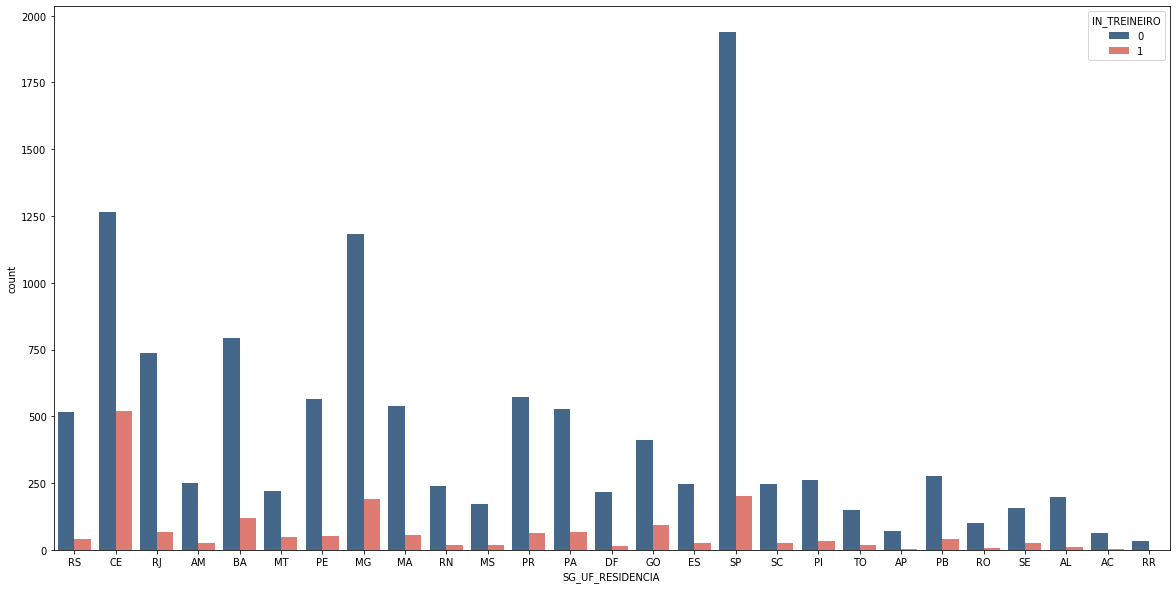

In [125]:
plt.figure(figsize=(20,10))
sns.countplot(x='SG_UF_RESIDENCIA', hue='IN_TREINEIRO', data=train, palette={0:'#386796',1:'#F06C61'})

#### Resultado
Aparentemente existe uma maior tendência dos treineiros serem do estado estado do Ceará. Todavia, nas análises iniciais essa feature não será considerada visto seu alto poder de enviesamento negativo. Além disso, o *encoding* da mesma pode trazer uma acréscimo de dimensionalidade elevada (cada estado receberia uma coluna) e portanto será removida futuramente. Porém, é uma informação relevante.

### Hipótese V - E as variáveis do questionário? Existem algum tipo de relação clara?

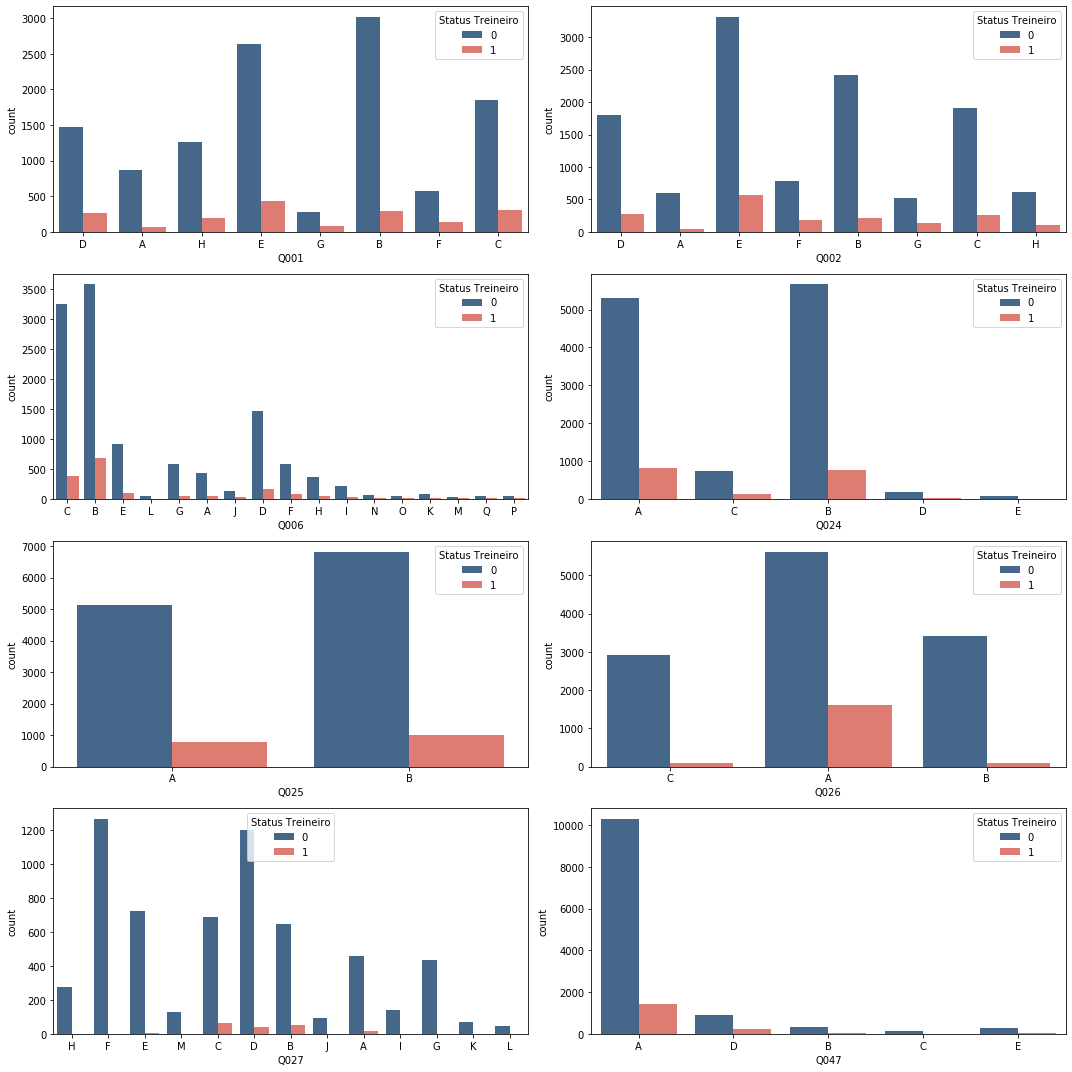

In [126]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

r = 0      # Index da linha
c = 0      # Index da coluna

# Loop nas features para plot
for f in ['Q001','Q002','Q006','Q024','Q025','Q026','Q027','Q047']:
    # Plot de barras
    sns.countplot(x=f, hue='IN_TREINEIRO', data=train, palette={0:'#386796',1:'#F06C61'}, ax=axes[r][c])
    # Configurações do plot
    axes[r][c].legend(title='Status Treineiro', loc='right upper')
    
    # Controle do index
    c += 1
    if c > 1:
        c = 0
        r += 1

# Configurações do plot x2
plt.tight_layout()

#### Resultado
Nenhuma categoria para nenhuma variável foi dominante. Essas variáveis também serão desconsideradas em análises futuras.

## Remoção de variáveis não utilizadas

In [127]:
# Estado e número de inscricao
train.drop(axis=1, inplace=True, columns=['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA'])

In [128]:
# Questionario
train.drop(axis=1, inplace=True, columns=['Q001','Q002','Q006','Q024','Q025','Q026','Q027','Q047'])

# Seleção de Features

Após toda essa análise mais exploratória feita na seção anterior. Temos alguns bons candidatos apresentados na tabela abaixo:

| Variáveis criadas                   | Variáveis originais |
|-------------------------------------|---------------------|
|`'NF_NAO_CONCLUIU_EM'`               | `'TP_ST_CONCLUSAO'` |
|`'NF_ANO_CONCLUSAO_NAO_INFORMADO'`   | `'TP_ANO_CONCLUIU'` |
|`'NF_EH_BR'`                         | `TP_NACIONALIDADE`  |
|`'NF_IDADE_BINARIA'` (*será criada*) | `'NU_IDADE'`        |
|`'NF_ESCOLA_NAO_INFORMADO'`          | `'TP_ESCOLA'`       |

Essas variáveis mostraram um bom poder de separação, visualmente falando, para a label `IN_TREINEIRO`.

Vamos ver como elas vão se sair durante essa fase de seleção. Porém antes de dar continuidade a essa seleção, vamos criar mais uma nova feature referente a idade:

In [133]:
max(train.loc[train['IN_TREINEIRO']==1, 'NU_IDADE']), min(train.loc[train['IN_TREINEIRO']==1, 'NU_IDADE'])

(18, 13)

In [134]:
# Fazendo a nova feature
train['NF_IDADE_BINARIA'] = train['NU_IDADE'] <= 18
train['NF_IDADE_BINARIA'] = train['NF_IDADE_BINARIA'].replace({False:0,True:1})

Temos agora uma nova feature a partir da idade que é menos complexa. Vamos fazer a seleção de features em dois conjuntos:
- treino com variáveis criadas menos complexas
- treino com variáveis originais

Usando `RFE` do sklearn com um modelo mais simples: `DecisionTree` (DT). A ideia desta seleção inicial é avaliar se um modelo simples como DT pode ter um bom poder preditivo.

In [135]:
# Criar dataset X para features criadas (1) e originais (2)
x1 = train[['NF_NAO_CONCLUIU_EM','NF_ANO_CONCLUSAO_NAO_INFORMADO','NF_EH_BR','NF_IDADE_BINARIA','NF_ESCOLA_NAO_INFORMADO']]
x2 = train[['TP_ST_CONCLUSAO','TP_ANO_CONCLUIU','TP_NACIONALIDADE','NU_IDADE','TP_ESCOLA']]

In [136]:
# Criar variável resposta Y
Y = train[label]

In [216]:
# Definir modelo estimador simples
modeloDT = DecisionTreeClassifier(random_state=1206,criterion='entropy')

In [217]:
# Definir o seletor para cada tipo
seletor_variaveis_1 = RFE(modeloDT, n_features_to_select=2)
seletor_variaveis_2 = RFE(modeloDT, n_features_to_select=2)

In [218]:
# Fit - Buscar melhor conjunto de features x1
seletor_variaveis_1 = seletor_variaveis_1.fit(x1, Y)

In [219]:
# Avaliar as selecionadas para o primeiro tipo de dado
list(x1.columns[seletor_variaveis_1.support_])

['NF_NAO_CONCLUIU_EM', 'NF_IDADE_BINARIA']

In [220]:
# Fit - Buscar melhor conjunto de features x2
seletor_variaveis_2 = seletor_variaveis_2.fit(x2, Y)

In [221]:
# Avaliar as selecionadas para o primeiro tipo de dado
list(x2.columns[seletor_variaveis_2.support_])

['TP_ST_CONCLUSAO', 'NU_IDADE']

o `RFE` retornou um resultado interessante: ambos os conjuntos retornaram as mesmas variáveis, ou seja, foi retornado o mesmo conjunto de variáveis criadas e originais. Vamos então partir para a construção de modelos com esses dois sets e avaliar através da submissão, qual alcança o melhor resultado.

# Construção de modelos

In [222]:
# Definir os datasets para criadas (1) e originais (2)
x1 = x1[['NF_NAO_CONCLUIU_EM', 'NF_IDADE_BINARIA']]
x2 = x2[['TP_ST_CONCLUSAO', 'NU_IDADE']]

In [239]:
# Definir os modelos
m1 = DecisionTreeClassifier(random_state=1206, class_weight='balanced',criterion='entropy')
m2 = DecisionTreeClassifier(random_state=1206, class_weight='balanced',criterion='entropy')

`class_weight` foi usado visto o desbalanceamento de amostras no dataset.

In [240]:
# Treinamento
m1.fit(x1, Y)
m2.fit(x2, Y);

In [241]:
# Avaliando uma métrica mais punitiva para conjunto de treinamento, considerando o desbalanceamento - F1 Score
print('M1 (DT com features criadas)   - F1-Score (%): ', 100*round(f1_score(Y, m1.predict(x1),average='macro'), 3))
print('M2 (DT com features originais) - F1-Score (%): ', 100*round(f1_score(Y, m2.predict(x2),average='macro'), 3))

M1 (DT com features criadas)   - F1-Score (%):  96.8
M2 (DT com features originais) - F1-Score (%):  96.8


In [242]:
# Avaliando uma métrica mais branda - Accuracy 
print('M1 (DT com features criadas)     - Accuracy (%): ', 100*round(accuracy_score(Y, m1.predict(x1)), 3))
print('M2 (DT com features originais)   - Accuracy (%): ', 100*round(accuracy_score(Y, m2.predict(x2)), 3))

M1 (DT com features criadas)     - Accuracy (%):  98.5
M2 (DT com features originais)   - Accuracy (%):  98.5


# Realizando as submissões

Aparentemente ambos os modelos mostraram resultados idênticos. Sempre que situações assim ocorrem, o modelo menos complexo prevalece. O que é o caso do `m1` que foi criado basicamente com variáveis binárias. Vamos ver se a complexidade do `m2` se reverte em melhores predições.

In [243]:
# Criar dataset auxiliar
aux = test.copy()

In [244]:
# Fazendo a nova feature 1/2
aux['NF_IDADE_BINARIA'] = aux['NU_IDADE'] <= 18
aux['NF_IDADE_BINARIA'] = aux['NF_IDADE_BINARIA'].replace({False:0,True:1})

In [245]:
# Fazendo a nova feature 2/2
aux['NF_NAO_CONCLUIU_EM'] = np.where(aux['TP_ST_CONCLUSAO'] == 3, 1, 0)

In [246]:
# Coletando as colunas essenciais
aux = aux[['NF_IDADE_BINARIA', 'NF_NAO_CONCLUIU_EM', 'NU_IDADE', 'TP_ST_CONCLUSAO', 'NU_INSCRICAO', 'IN_TREINEIRO']]

In [247]:
# Separando os conjuntos de acordo as features
xt1 = aux[['NF_NAO_CONCLUIU_EM', 'NF_IDADE_BINARIA']]
xt2 = aux[['TP_ST_CONCLUSAO', 'NU_IDADE']]

In [248]:
# Realizar predições
yt1 = m1.predict(xt1)
yt2 = m2.predict(xt2)

In [249]:
# Verificar se os resultados são equivalentes
sum(yt1 == yt2)/len(aux)

1.0

Ambos os modelos preveram o mesmo resultado. Logo, não precisa de uma comparação por submissão: o modelo mais simples será usado para realizar as predições:

In [250]:
# Salvando resultado no dataset auxiliar
aux['IN_TREINEIRO'] = yt1

In [251]:
# Salvando CSV - Submissão
aux[['NU_INSCRICAO','IN_TREINEIRO']].to_csv('answer.csv', index=False)

Pela submissão, foi alcançado **98.73%**. Um resultado impressionante para um modelo tão simples.

# Analisando os resultados encontrados pelo modelo

Como usamos um modelo com um teor interpretativo como DT vamos analisar características intrínsecas a ele:
- *Feature Importance*
- Árvore de decisão

## Módulos necessários

In [268]:
from math import sqrt
from scipy.stats import chi2_contingency
from sklearn.tree import plot_tree

## Feature Importance

In [253]:
# Criar dataset para seaborn
df_featImp = pd.DataFrame(columns=['Feature', 'Importance'])
df_featImp['Feature'] = x1.columns
df_featImp['Importance'] = m1.feature_importances_
df_featImp.sort_values('Importance', ascending=False, inplace=True)

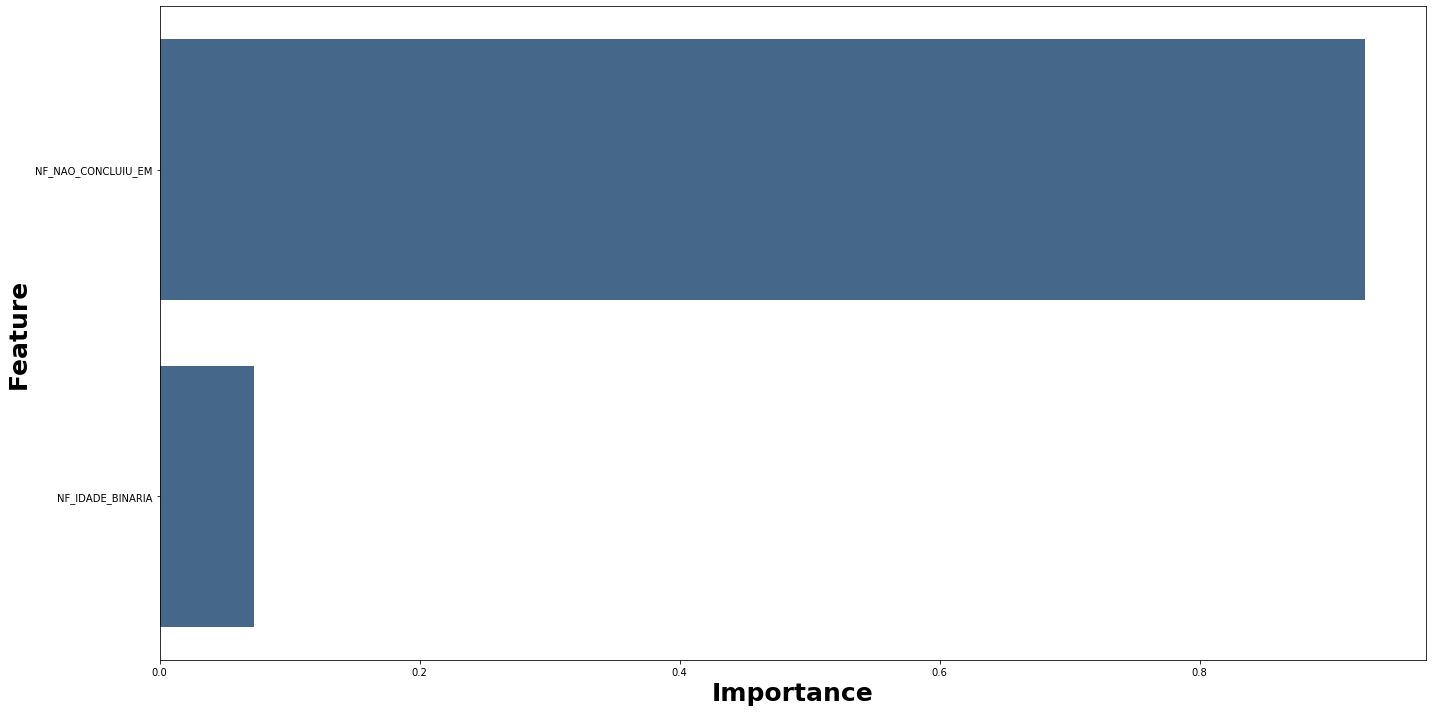

In [254]:
# Plot
fig = plt.figure(figsize=(20,10))
sns.barplot(x="Importance",y='Feature', data=df_featImp, color='#386796')
plt.xlabel('Importance',fontsize=25,fontweight='bold')
plt.ylabel('Feature',fontsize=25,fontweight='bold')
plt.tight_layout();

Aparentemente `NF_NAO_CONCLUIU_EM` é a feature mais relevante. Porém é importante destacar que um dos *pitfalls* dessa análise é que variáveis altamente correlacionadas tendem a apresentar uma diferença discrepante. Vamos avaliar se essas features de fato são tão correlacionadas através do **V's Crammer** (medida de correlação para features categóricas):

**PS**: [Referência do código usado aqui](https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix) porém com uma correção através da adição da `sqrt` faltante da formula no final.

In [255]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1, var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return sqrt(stat/(obs*mini))

In [256]:
print('Cramer V:', round(cramers_V(x1['NF_NAO_CONCLUIU_EM'], x1['NF_IDADE_BINARIA']), 3))

Cramer V: 0.369


Uma baixa correlação foi encontrada para essas features. Isso pode indicar que existe a possibilidade de gerar um modelo com apenas uma feature (a mais importante). Vamos analisar rapidamente essa possibilidade:

In [258]:
# Definir os modelos
m1_extra = DecisionTreeClassifier(random_state=1206, class_weight='balanced',criterion='entropy')
x1_extra = np.array(x1['NF_NAO_CONCLUIU_EM']).reshape(-1, 1)
# Treinamento
m1_extra.fit(x1_extra, Y)
# Avaliando uma métrica mais punitiva para conjunto de treinamento, considerando o desbalanceamento - F1 Score
print('M1 c/ 1 Feature - F1-Score (%): ', 100*round(f1_score(Y, m1_extra.predict(x1_extra),average='macro'), 3))
# Avaliando uma métrica mais branda - Accuracy 
print('M1 c/ 1 Feature - Accuracy (%): ', 100*round(accuracy_score(Y, m1_extra.predict(x1_extra)), 3))

M1 c/ 1 Feature - F1-Score (%):  92.5
M1 c/ 1 Feature - Accuracy (%):  96.2


O modelo perde o seu poder preditivo, porém é interessante avaliar como uma única feature consegue manter o poder preditivo. Vamos dar uma olhada nas árvores geradas...

## Árvores de decisão

Para entender as árvores mostradas a seguir antes é necessário compreender que:
- Temos 13730 amostras. Esse valor vai se quebrando ao decorrer que a árvore vai crescendo.
- Caso siga um caminho para a esquerda, isso implica que a condição do nó pai foi respeitada. Caso contrário, siga para a direita.
- Para este caso temos duas simples variáveis binárias com as seguintes definições:

`NF_NAO_CONCLUIU_EM` é `1` para estudantes que não concluiram o ensino médio e `0` para os demais casos.

`NF_IDADE_BINARIA` (o nome dessa variável não ajuda muito, eu sei) é `1` para estudantes com idade igual ou inferior a 18 anos e `0` para estudantes acima de 18.

Com isso em mãos, vamos analisar: 

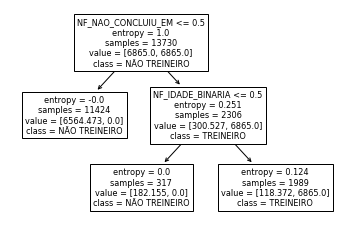

In [266]:
# Modelo principal
plot_tree(decision_tree=m1, feature_names=x1.columns, class_names=['NÃO TREINEIRO','TREINEIRO']);

#### Explicação
A principal feature (mais no topo) é `NF_NAO_CONCLUIU_EM` como foi denotado pela *Feature Importance*. Note que o corte no primeiro nó é `<= 0.5`, porém você pode interpretar como `NF_NAO_CONCLUIU_EM == 0` já que é uma variável binária. Como é uma árvore pequena vamos seguir essa árvore:
- Ao encontrar um estudante que já concluiu o EM (`NF_NAO_CONCLUIU_EM == 0`) ele automaticamente desce para a esquerda e como é um nó folha o resultado gerado é: `NÃO TREINEIRO` (`0`).
- Ao encontrar um estudante que não concluiu o EM (`NF_NAO_CONCLUIU_EM == 1`) ele desce para a direita e por enquanto é classificado como `TREINEIRO` (`1`).
    - Caso o estudante tenha idade maior que 18 anos (`NF_IDADE_BINARIA == 0`) Ele vai para o nó da **esquerda** onde é classificado como `NÃO TREINEIRO` (`0`).
    - Porém caso o estudante tenha menos de 18 anos (`NF_IDADE_BINARIA == 1`) ele é classificado como `TREINEIRO` (`1`).

Essa última resposta faz até sentido na vida real: é muito complicado para um estudante que não completou o ensino médio e que é menor de idade entrar em uma faculdade. Essa simples árvore de decisão mostra que um simples programa de `if else` poderia resolver nossa situação (para esse caso).

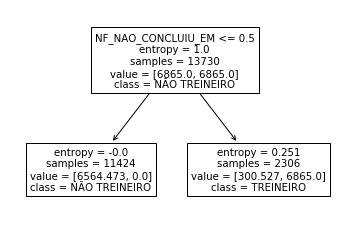

In [267]:
# Modelo com apenas uma feature
plot_tree(decision_tree=m1_extra, feature_names=['NF_NAO_CONCLUIU_EM'], class_names=['NÃO TREINEIRO','TREINEIRO']);

#### Explicação
Aqui a explicação é ainda mais simples e pode ser resumida a um `if else`: Se o estudante já concluiu o EM (`NF_NAO_CONCLUIU_EM == 0`) ele é classificado com `NÃO TREINEIRO` (`0`). Se ele ainda não concluiu, ele é então classificado como `TREINEIRO` (`1`).

Essa resposta faz também muito sentido: A maioria das pessoas que realizam o ENEM após o ensino médio são pessoas que provavelmente almejam entrar em uma faculdade/universidade. Afinal devem ser raras as pessoas que perderiam dois finais de semanas após o EM para testar suas habilidades.

# Conclusão
Este desafio de classificação é interessante. Ele mostra bastante o poder de uma boa feature engineering. De 43 colunas chegamos a 2 colunas binárias em um modelo relativamente simples com excelentes resultados: **98.73%**. 

Além disso, através da análises interpretativas do modelo conseguimos entender exatamente como funciona a regra de decisão atrelada ao problema afinal quais são as chances de fazermos o enem por diversão?